<font size="+3"><strong>JNB1 Predicting Price with Size</strong></font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Prepare Data

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_price = df["price_aprox_usd"] < 400000
    mask_property_type = df["property_type"] == "apartment"
    
    df = df[mask_ba & mask_price & mask_property_type]
    
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_surface = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_surface]
    
    return df

In [3]:
df = wrangle("data/argentina_realestate_1.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   8606 non-null   object 
 1   property_type               8606 non-null   object 
 2   place_with_parent_names     8606 non-null   object 
 3   lat-lon                     6936 non-null   object 
 4   price                       7590 non-null   float64
 5   currency                    7590 non-null   object 
 6   price_aprox_local_currency  7590 non-null   float64
 7   price_aprox_usd             7590 non-null   float64
 8   surface_total_in_m2         5946 non-null   float64
 9   surface_covered_in_m2       7268 non-null   float64
 10  price_usd_per_m2            4895 non-null   float64
 11  price_per_m2                6520 non-null   float64
 12  floor                       1259 non-null   float64
 13  rooms                       4752 

In [4]:
df = df[df["property_type"]=="apartment"]
df= df[df["place_with_parent_names"].str.contains("Capital Federal")]
df= df[df["price_aprox_usd"]<400000]
df.shape

(1781, 16)

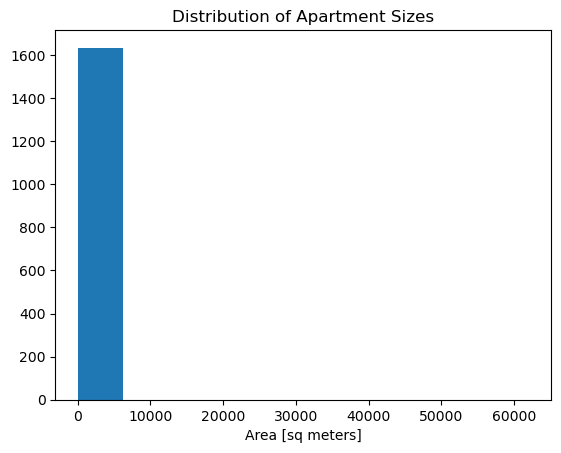

In [5]:
# Distribution of apartment sizes 
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

In [6]:
# we look at the summary statistics of the column to confirm the outliers
df["surface_covered_in_m2"].describe()

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

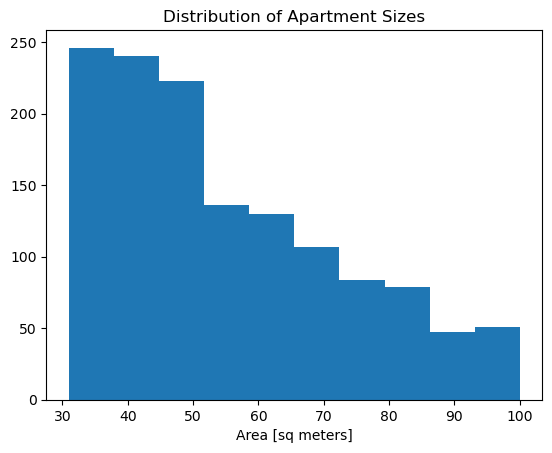

In [7]:
# Got rid of the outliers
# low, high = df["surface_covered_in_m2"].quantile([0.1,0.9])
# mask_surface = df["surface_covered_in_m2"].between(low, high)
# df = df[mask_surface]

plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

In [8]:
# For purposes of reproducibility and avoiding mistakes that 
# could arise from running code snippets twice, I will add
# our data cleaning code to my wrangle function and comment it out else where
# to maintain visibility of how arrived to it.

# Split 

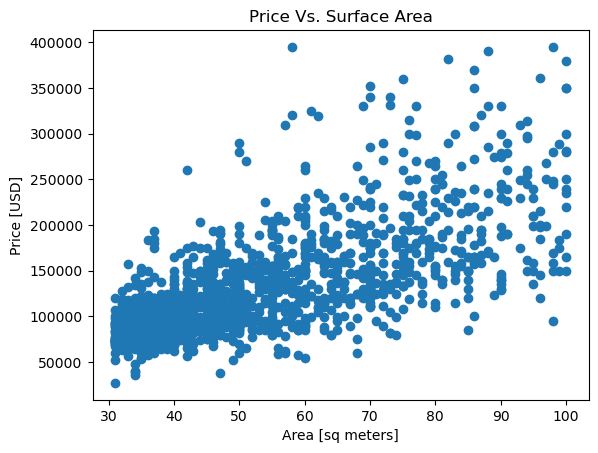

In [9]:
# Exploring the relationship between the price and the surface area covered by apartments
plt.scatter( x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Price Vs. Surface Area");
#This suggests a moderate correlation between size and prices

In [10]:
# Seeing there is a correlation, I will be using surface size to predict apartment price
X_train = df[["surface_covered_in_m2"]]
y_train = df["price_aprox_usd"]

In [11]:
X_train.shape

(1343, 1)

In [12]:
y_train.shape

(1343,)

# Build Model

## Baseline

In [23]:
# First I will create the naive baseline model which will help us gauge how well our model will be performing

y_mean = round(y_train.mean(), 2)
y_mean

135527.84

In [24]:
# I will now make y_pred_baseline a list of y predictions to match our target vector y_train length

y_pred_baseline = [y_mean for i in y_train]
len(y_pred_baseline)

1343

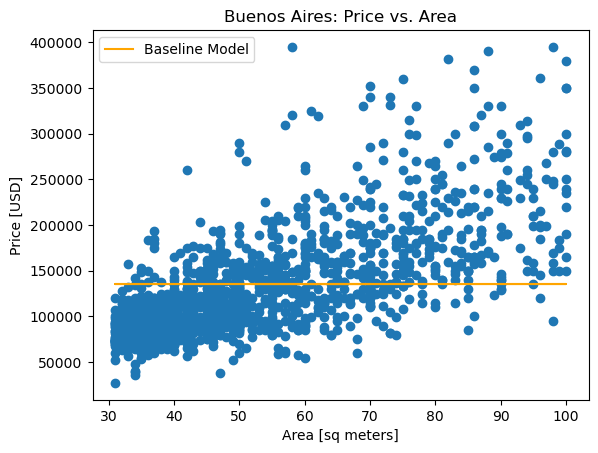

In [22]:
plt.plot(X_train["surface_covered_in_m2"], y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [27]:
# mean absolute error baseline
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


## Iterate

The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance. Even though the model we're building is linear, the iteration process rarely follows a straight line.

The first thing we need to do is create our model — in this case, one that uses linear regression.

In [28]:
model = LinearRegression()

In [29]:
model.fit(X_train, y_train)

LinearRegression()

## Evaluate

The final step is to evaluate our model. In order to do that, we'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in our training set.

In [32]:
y_train_pred = model.predict(X_train)
y_train_pred[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [31]:
mae = mean_absolute_error(y_train, y_train_pred)
mae

31248.2561380616

Good news: The model beat the baseline by over $10,000! That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that I took off as test data when I split my df.

## Generalizability

Generalizability has to do with how well your mode will work with other data. 
Ideally, you want your test performance metrics to be the same as its training performance metrics. In practice, test metrics tend to be a little worse (this means a larger number in the case of mean absolute error). But as long as the training and test performance are close to each other, you can be confident that your model will generalize well.

In [35]:
test_df = pd.read_csv("data/argentina_realestate_test_data.csv")
test_matrix_feature = test_df[["surface_covered_in_m2"]]
test_matrix_feature.shape

(1486, 1)

In [38]:
test_matrix_feature = test_matrix_feature[:1343]
test_matrix_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   surface_covered_in_m2  1343 non-null   int64
dtypes: int64(1)
memory usage: 10.6 KB


In [40]:
test_pred = model.predict(test_matrix_feature)
test_pred[:5]

array([117330.05890084, 135355.03782307,  88039.46815224,  88039.46815224,
       106064.44707446])

In [41]:
#At this point if you had the actual readings you could establish the MAE for the test data and 
#for this in future I will be splitting the data I have into train and test data

## Communicating Results

Once your model is built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation. When we created our baseline model, we represented it as a line. The equation for a line like this is usually written as:

<center><img src="images/img-4.png" alt="Equation: y = m*x + b" style="width: 400px;"/></center>

Since data scientists often work with more complicated linear models, they prefer to write the equation as:

<center><img src="images/img-3.png" alt="Equation: y = beta 0 + beta 1 * x" style="width: 400px;"/></center>

Regardless of how we write the equation, we need to find the values that our model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself. Let's start with the intercept.

Extract the intercept from your model, and assign it to the variable intercept.

In [46]:
intercept = round(model.intercept_, 2)
print("Model Intercept:", intercept)

Model Intercept: 11433.31


Next comes the coefficient. We'll extract it in a very similar way.

In [45]:
coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)

Model coefficient for "surface_covered_in_m2": 2253.12


In [47]:
print(f"apartment price = {intercept} + {coefficient} * apartment surface area in m^2")

apartment price = 11433.31 + 2253.12 * apartment surface area in m^2


A line below that shows the relationship between the observations in `X_train` and your model's predictions `y_train_pred`. Be sure that the line color is red, and that it has the label `"Linear Model"`.

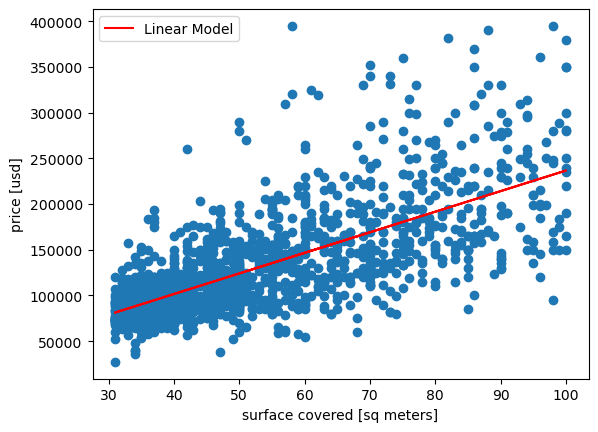

In [49]:
plt.plot(X_train, y_train_pred, color="red", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();